In [1]:
import win32com.client
from datetime import date
import numpy as np
import time
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import visa # provides generic usb interface to the powermeter
from ThorlabsPM100 import ThorlabsPM100 # actually knows how to talk to the powermeter
%matplotlib notebook

## set basic parameters below

In [2]:
### set folder here

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()

# type your name here (formated as in F drive)
name = 'rlees'

folder = r"F:\Data\{0}\{1}\PowerMeasurements".format(name, datestring)

if not os.path.exists(folder):
    os.makedirs(folder)
    
folder

'F:\\Data\\rlees\\2019-03-12\\PowerMeasurements'

In [3]:
class DigitalPowerMeasurer:
    """
    This class takes analog devices on an AI card, a usb connection to the power meters, 
    a PrairieLink, and xmls and gpls to definethe SLM experiment.
    It then fires the experiment once to find the best power range, 
    initializes the analog devices, starts the SLM experiments and listens to the analog inputs.
    returns a power range array and the analog input array."""
    
    def __init__(self,prairie_link, visa_resource_manager, power_meter_list):
        
        # store configruation
        self.pl = prairie_link
        self.rm = visa_resource_manager
        self.num_power_meters = len(power_meter_list)
        
        # create power_meters
        self.instruments = []
        self.power_meters = []
        for i in range(self.num_power_meters):
            self.instruments.append(rm.open_resource(power_meter_list[i]))
            self.power_meters.append(ThorlabsPM100(inst=self.instruments[i]))
        
    def measure(self,laser_name,wavelength,laser_power,window_length=5):
        """
        laser name needs to match a laser name in PrairieView
        Wavelength needs to be accessible trhough the PrairieView 2P laser tab
        take {laser_name:laser_power[PV]} dictionary and perform measurement with this power for 3s"""
        
        voltage_array = np.zeros(self.num_power_meters)
        
        pl.SendScriptCommands('-SetLaserPower ' + laser_name + ' ' + str(laser_power))
        time.sleep(window_length)
        
        for i in range(self.num_power_meters):
            # set the power meter wavelength
            self.power_meters[i].sense.correction.wavelength = wavelength
            
            # use USB correction to measure current power
            voltage_array[i] = self.power_meters[i].read
        
        pl.SendScriptCommands('-SetLaserPower ' + laser_name + ' ' + str(0))
        
        return voltage_array

In [4]:
def pockel_curve(x,I,k,phi):
    return I * np.cos(k*x + phi)**2

def arctangent(x, phi, I_0, I, k):
    return I * np.arctan(k*(x + phi)) + I_0

In [5]:
# Start PrairieLink
pl = win32com.client.Dispatch('PrairieLink.Application')
print('object created')

# Connect to Client
pl.Connect()
print(pl.Connected)

object created
<bound method Connected of <COMObject PrairieLink.Application>>


In [6]:
# Search for PowerMeters
rm=visa.ResourceManager()
resource_list = rm.list_resources()
print(resource_list)

# create powermeter, assume that it is the first object showing up in the above list
pm100 = DigitalPowerMeasurer(pl,rm,[resource_list[0]])

('USB0::0x1313::0x8079::P1003857::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR', 'ASRL6::INSTR', 'ASRL7::INSTR', 'ASRL10::INSTR', 'ASRL11::INSTR', 'ASRL12::INSTR', 'ASRL13::INSTR')


# MAKE sure you:
## open laser shutters
## center galvos
## check if you are in resonant galvo mode
## check PMT shutters are closed
## think about SLM if using uncaging
## plug in power meter if low battery
## check the conoptics bias voltage is set to -017
## set the GDD to 14212 using the slider or up/down arrows

In [9]:
laser_name = 'Imaging'
wavelength = 765
#pl.SendScriptCommands('-SetMultiPhotonWavelength' + ' ' + str(wavelength) + ' ' + str(1))
#Allow Chameleon to change its colours
#time.sleep(15)

powerspace = np.arange(0,1100,100)

len_powerspace = len(powerspace)

voltage_array = np.zeros(len_powerspace)

for i in range(len_powerspace):
    voltage_array[i] = pm100.measure('Imaging', wavelength, powerspace[i],6)
    #time.sleep(3)
    print(voltage_array[i])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.00132833212
0.0247953869
0.0742387548
0.134013519
0.193935782
0.238803834
0.26271373
0.267141461
0.246773735
0.208990186
0.157333001


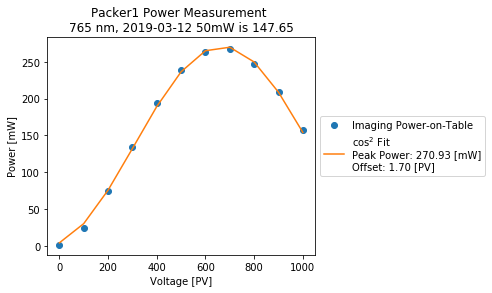

In [10]:
guess = (0.14,1/500,1)
popt, pcov = curve_fit(pockel_curve,powerspace,voltage_array,guess)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power-on-Table')
ax.plot(powerspace,1000*pockel_curve(powerspace,*popt),label=r"cos$^{2}$ Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format(popt[0]*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[2]))


#numerically get the PV power for 50mW
test_PVs = np.linspace(0,500,1000)
power = []
for i in test_PVs:
    
    power.append(pockel_curve(i,*popt) * 1000)
    
fifty_diff = [50 - i for i in power]
fifty_IND = np.argmin(np.abs(fifty_diff))
fifty_PV = np.round(test_PVs[fifty_IND],2)


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring + ' 50mW is {}'.format(fifty_PV))

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()
operator = "mloidolt"

os.chdir(folder)
plt.savefig(datestring+'_'+laser_name+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'powerspace',powerspace)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'voltage_array',voltage_array)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'popt',popt)
np.save(datestring+'_'+laser_name+'_'+str(wavelength)+'_'+'pcov',pcov)

## no longer have 2p laser tab, so change laser wavelength manually
## the power meter wavelength is set automatically

# be very careful not to go above 800 PV if using uncaging path 
# Pmax = 5W for the thermosensor
# be even MORE careful if using the wand Pmax = 0.5W
# Make sure at 1x zoom
# change phase mask to SLMSingleSpot_PhaseMask_PowerMeasurement


In [11]:
## set the uncaging path to measure here

#uc_path = 'uncaging_no_slm'
uc_path = 'uncaging_slm_single_spot' 


In [12]:
uc_path

'uncaging_slm_single_spot'

In [13]:
# Start PrairieLink if had to restart PV
pl = win32com.client.Dispatch('PrairieLink.Application')
print('object created')

# Connect to Client
pl.Connect()
print(pl.Connected)

object created
<bound method Connected of <COMObject PrairieLink.Application>>


In [14]:
# dont try hack this to make it faster, it causes errors

laser_name = 'Uncaging'
wavelength = 1030

if uc_path == 'uncaging_no_slm':
    powerspace = np.arange(200,750,50)
elif uc_path == 'uncaging_slm_single_spot':
    powerspace = np.arange(200,1100,100)
else:
    raise('invalid uncaging path')


len_powerspace = len(powerspace)

voltage_array = np.zeros(len_powerspace)

for i in range(len_powerspace):
    print(powerspace[i])
    voltage_array[i] = pm100.measure(laser_name, wavelength, powerspace[i],window_length=7)
    print(voltage_array[i])
    #time.sleep(3)
    
assert max(voltage_array) < 10, 'if power meter is not allowed to reset long enough between measurements, an error can be raised here'

200


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


0.000755613088
300
0.0116371661
400
0.0466997884
500
0.0953643471
600
0.153248027
700
0.196320683
800
0.221559793
900
0.230023116
1000
0.238335401


[ 200  300  400  500  600  700  800  900 1000]
[0.00075561 0.01163717 0.04669979 0.09536435 0.15324803 0.19632068
 0.22155979 0.23002312 0.2383354 ]


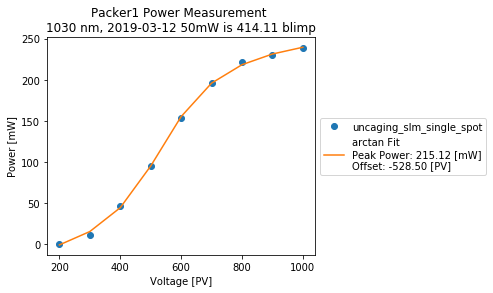

In [15]:
datestring = date.today().isoformat()
guess = (-700,500,300,0.02)
popt, pcov = curve_fit(arctangent,powerspace,voltage_array,guess)

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=uc_path)
ax.plot(powerspace,1000*arctangent(powerspace,*popt),label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[0]))

#numerically get the PV power for 50mW
test_PVs = np.linspace(200,500,1000)
power = []
for i in test_PVs:    
    power.append(arctangent(i,*popt) * 1000)
    
fifty_diff = [50 - i for i in power]
fifty_IND = np.argmin(np.abs(fifty_diff))
fifty_PV = np.round(test_PVs[fifty_IND],2)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
#plt.title("Packer1 Power On Sample \n" + str(wavelength) + " nm " + ' ' + uc_path + "\n" + datestring)
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring + ' 50mW is {}'.format(fifty_PV) + ' blimp')

# construct Packer-xkcd-compliant datestring
datestring = date.today().isoformat()
operator = "mloidolt"

os.chdir(folder)
plt.savefig(datestring+'_'+uc_path+'_'+str(wavelength)+".pdf",bbox_extra_artists=(legend,), bbox_inches='tight')
np.save(datestring+'_'+uc_path+'_'+str(wavelength)+'_'+'powerspace',powerspace)
np.save(datestring+'_'+uc_path+'_'+str(wavelength)+'_'+'voltage_array',voltage_array)
np.save(datestring+'_'+uc_path+'_'+str(wavelength)+'_'+'popt',popt)
np.save(datestring+'_'+uc_path+'_'+str(wavelength)+'_'+'pcov',pcov)

print(powerspace);
print(voltage_array);

In [ ]:
folder = r"F:\Data\mloidolt\2018-09-05\2018-09-05_PowerMeasurements"
os.chdir(folder)

datestring = date.today().isoformat()

laser_name = 'Uncaging'
wavelength=1030

powerspace = np.load("2018-09-05_Uncaging_1030_powerspace.npy")
voltage_array = np.load("2018-09-05_Uncaging_1030_voltage_array.npy")
stable_popt = np.load("2018-09-05_Uncaging_1030_popt.npy")

Y = I/2 * 680
X = PV

old_popt = np.load(r"F:\Data\mloidolt\2018-08-23\2018-08-23_PowerMeasurements\2018-08-23_Uncaging_1030_popt.npy")
powerspace = np.arange(300,1000,30)

guess = (-700,500,300,0.02)

popt, pcov = curve_fit(arctangent,X,Y,guess)
print(popt)
print(old_popt)

fig = plt.figure()
ax = plt.subplot(111)

#plt.plot(powerspace,arctangent(powerspace,*old_popt)/multiplicator)
ax.plot(X,Y,linestyle='None',marker='o',color='blue',label=laser_name + ' Peak Power')
ax.plot(powerspace,arctangent(powerspace,*popt),color='blue',label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(popt[0]))
ax.plot(powerspace,1000*voltage_array,linestyle='None',marker='o',label=laser_name + ' Power afer 5s',color='green')
ax.plot(powerspace,1000*arctangent(powerspace,*stable_popt),label=r"arctan Fit" + "\n"
         r"Peak Power: {:.2f} [mW]".format((popt[2]+popt[1])*1000) + "\n" +
         "Offset: {:.2f} [PV]".format(old_popt[0]),color='green')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Voltage [PV]")
plt.ylabel("Power [mW]")
plt.title("Packer1 Power Measurement \n" + str(wavelength) + " nm, " + datestring)